In [89]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels import regression
from statsmodels.tsa.stattools import coint

In [90]:
data = pd.read_excel('/home/daniel/Desktop/Projetos/mql_python/Relatório 1/dados_relatorio.xlsx')

In [121]:
def seleciona_dados(s1,s2):
    _tick1 = s1[6:]
    _tick2 = s2[6:]

    dados = data[[s1,s2]].copy()
    dados[('Ch'+_tick1)],dados[('Ch'+_tick2)] = dados[s1].pct_change(),dados[s2].pct_change()
    dados = dados[1:]
    dados.columns = [_tick1,_tick2,s1,s2]
    return dados

def calcula_zscore_spread(dados, period):
    c = 0
    list_zs = [None]*period
    for i in range(period,len(dados)):
        S1 = dados[s1][c:i]
        S2 = dados[s2][c:i]
        S1 = sm.add_constant(S1)
        results = sm.OLS(S2,S1).fit()
        S1 = S1[s1]
        b = results.params[s1]
        spread = S2 - (b*S1)
        zs = zscore(spread)
        list_zs.append(zs[-1])
        c+=1
    return list_zs

def operador(dados, gatilho, encerra, carteira, t1,t2):
    posicao = 0 #1 - posicionado | 0 - neutro
    compra = 0
    venda = 0
    
    fin_long  = 0 #financeiro ponta long
    fin_short = 0 #financeiro ponta short 
    l_resultado = []
    
    for index in range(len(dados)):
        zs = dados['zs_spread'][dados.index == index+1].values[0]
        p_s1 = float(dados[t1][dados.index == index+1].values)
        p_s2 = float(dados[t2][dados.index == index+1].values)
        #abre operacao  
        if zs <= -gatilho and posicao == 0:
            q = (p_s1/p_s2) 
            v = carteira/2/p_s1   #volume de acordo com carteira
            
            fin_long  -= p_s1*v   #debito financeiro - long
            fin_short += p_s2*v*q #credito financeiro - short 
            
            posicao = 1 #esta posicionado
        #abre operacao
#         elif zs >= gatilho and posicao == 0:
#             q = (p_s1/p_s2) 
#             v = carteira/2/p_s1 #volume de acordo com carteira
            
#             fin_long  -= p_s1*v   #debito financeiro - long
#             fin_short += p_s2*v*q #credito financeiro - short 
            
#             posicao = 1 #esta posicionado
        #encerra
        elif (zs > -encerra and zs < encerra) and posicao == 1:
#             print(f' C {compra:.2f} | V {venda:.2f} | ')
            fin_long   += p_s1*v   #creditando venda da posicao
            fin_short  -= p_s2*v*q #debita encerramento posicao
            
            posicao = 0 #esta neutro
            
            resultado = fin_long + fin_short
#             print(f'res: {resultado:.2f} | l:{fin_long:.2f} | s:{fin_short:.2f}\n')
            l_resultado.append(resultado)
            carteira += resultado
            print(carteira)
#             #reseta
#             compra = 0
#             venda = 0
            
    return l_resultado

In [122]:
s1,s2 = 'close ITUB4','close ITSA4'
dados = seleciona_dados(s1=s1,s2=s2)

In [123]:
dados['zs_spread'] = calcula_zscore_spread(dados,period=60)

In [124]:
dados

,ITUB4,ITSA4,close ITUB4,close ITSA4,zs_spread
1,10.60,3.82,0.000944,0.000000,NaN
2,10.52,3.81,-0.007547,-0.002618,NaN
3,10.60,3.83,0.007605,0.005249,NaN
4,10.66,3.85,0.005660,0.005222,NaN
5,10.80,3.91,0.013133,0.015584,NaN
...,...,...,...,...,...
1970,35.38,13.37,-0.004502,-0.008895,-0.638311
1971,35.71,13.46,0.009327,0.006731,-0.968038
1972,36.26,13.70,0.015402,0.017831,-0.187687
1973,36.16,13.64,-0.002758,-0.004380,0.872762


In [125]:
t1,t2 = 'ITUB4','ITSA4'
gats = [1.1]
encr = [.08]
capital = 10000
testes = []

for i in gats:
    for j in encr:
        result = operador(dados,gatilho=i,encerra=j,carteira=capital,t1=t2,t2=t1)
        testes.append(result)

10125.718106518565
10269.79060520707
10364.233598307246
10478.301429397938
10626.393566239516
10776.682220186965
10857.48294213917
11047.559418061732
11236.752439785476
11394.81712262641
11542.904291154282
11685.062342426896
11853.565638891081
12052.714878264858
12192.630080368826
12358.450071660034
12432.235488535865
12525.987806871155
12574.356111413432
12706.432313596302
12710.624140744565
12504.950721137395
12206.175885547036
12030.936258054418
11905.224514534113
11728.173159875729
11554.69534766839
11381.961031779412
11262.376228291958
11078.40234071129
11015.45288243454
11027.40946299415
11071.386447503925
11080.002755551617
11075.072796523895
11147.836714306239
11159.290007035288
11399.09558720897
11455.593432490765
11504.859134903898
11569.16074014665
11652.335971220156
11738.063614775736
11629.39695701568
11571.463458679542
11655.630538782581
11936.76725503679
12193.974553363425
12463.027925752536
12739.69892195605
13159.162454451656
13483.125960305695
13759.571759609104
13856

Soma: 50948.8093 | Gati=1.1,Encr=0.08
                 0
count    87.000000
mean    585.618497
std     939.988955
min    -298.774836
25%      68.532762
50%     189.193022
75%     675.795717
max    3991.760626




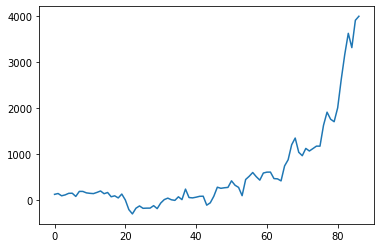

In [126]:
cont = 0
for i in gats:
    for j in encr:
        des = pd.DataFrame(testes[cont])
        print(f'Soma: {float(des.sum()):.4f} | Gati={i},Encr={j}')
        print(des.describe())
        print('\n')
        plt.plot(des)
        cont+=1

In [127]:
des[0].sum()

50948.80926585839

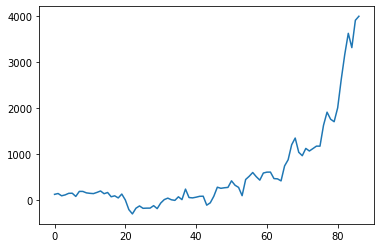

In [128]:
plt.plot(des[0])

In [99]:
def operador2(dados, gatilho, encerra, carteira, t1,t2):
    posicao = 0 #1 - posicionado | 0 - neutro
    compra = 0
    venda = 0
    
    fin_long  = 0 #financeiro ponta long
    fin_short = 0 #financeiro ponta short 
    l_resultado = []
    l_cart = []
    
    for index in range(len(dados)):
        zs = dados['zs_spread'][dados.index == index+1].values[0]
        p_s1 = float(dados[t1][dados.index == index+1].values)
        p_s2 = float(dados[t2][dados.index == index+1].values)

        #abre operacao
        if zs >= gatilho and posicao == 0:
            q = (p_s1/p_s2) 
            v = carteira/2/p_s1 #volume de acordo com carteira
            
            fin_long  += p_s1*v   # 
            fin_short -= p_s2*v*q #  
            
            posicao = 1 #esta posicionado
        #encerra
        elif (zs > -encerra and zs < encerra) and posicao == 1:
#             print(f' C {compra:.2f} | V {venda:.2f} | ')
            fin_long   -= p_s1*v   #creditando venda da posicao
            fin_short  += p_s2*v*q #debita encerramento posicao
            
            posicao = 0 #esta neutro
            
            resultado = fin_long + fin_short
#             print(f'res: {resultado:.2f} | l:{fin_long:.2f} | s:{fin_short:.2f}')
            l_resultado.append(resultado)
            carteira+=resultado
            l_cart.append(carteira)
#             print(f'cart: {carteira:.2f}\n')
            
    return l_resultado, l_cart

In [131]:
t1,t2 = 'ITUB4','ITSA4'
gats = [1.3,1.4,1.5]
encr = [.08]
capital = 10000
testes = []

for i in gats:
    for j in encr:
        result = operador2(dados,gatilho=i,encerra=j,carteira=capital,t1=t2,t2=t1)
        trades = result[0]
        testes.append(trades)

res: -108.89 | l:158.05 | s:-266.94
cart: 9891.11

res: -162.53 | l:142.88 | s:-305.41
cart: 9728.58

res: -50.20 | l:354.37 | s:-404.56
cart: 9678.38

res: -130.41 | l:323.64 | s:-454.06
cart: 9547.96

res: -110.31 | l:361.73 | s:-472.04
cart: 9437.66

res: -197.32 | l:796.53 | s:-993.85
cart: 9240.33

res: -164.85 | l:743.88 | s:-908.73
cart: 9075.48

res: -180.84 | l:581.37 | s:-762.21
cart: 8894.64

res: -197.24 | l:769.44 | s:-966.68
cart: 8697.39

res: -145.04 | l:997.72 | s:-1142.76
cart: 8552.35

res: -114.54 | l:1072.30 | s:-1186.85
cart: 8437.80

res: -65.70 | l:901.59 | s:-967.29
cart: 8372.11

res: -101.17 | l:858.66 | s:-959.84
cart: 8270.93

res: 19.72 | l:732.39 | s:-712.67
cart: 8290.65

res: -17.53 | l:827.32 | s:-844.85
cart: 8273.13

res: -1.99 | l:816.60 | s:-818.60
cart: 8271.13

res: 109.28 | l:869.22 | s:-759.93
cart: 8380.42

res: 171.10 | l:170.85 | s:0.25
cart: 8551.52

res: 155.75 | l:4.90 | s:150.85
cart: 8707.26

res: 245.15 | l:-487.78 | s:732.93
cart: 895

res: 325.69 | l:-1607.03 | s:1932.71
cart: 11755.76

res: 355.78 | l:-1619.10 | s:1974.88
cart: 12111.54

res: 379.41 | l:-2002.83 | s:2382.24
cart: 12490.95

res: 383.11 | l:-1990.29 | s:2373.40
cart: 12874.07

res: 399.21 | l:-2128.31 | s:2527.53
cart: 13273.28

res: 697.12 | l:-1287.41 | s:1984.53
cart: 13970.40

res: 831.56 | l:-956.29 | s:1787.84
cart: 14801.95

res: 1075.22 | l:-1086.70 | s:2161.92
cart: 15877.17

res: 1165.60 | l:-864.64 | s:2030.24
cart: 17042.77

res: 805.78 | l:-973.61 | s:1779.39
cart: 17848.55

res: 942.73 | l:-973.61 | s:1916.34
cart: 18791.27

res: 1012.39 | l:-594.76 | s:1607.15
cart: 19803.66

res: 1032.35 | l:21.70 | s:1010.65
cart: 20836.01

res: 1043.44 | l:-166.69 | s:1210.13
cart: 21879.45

res: 1374.27 | l:-1624.03 | s:2998.29
cart: 23253.72

res: 1024.53 | l:-3019.96 | s:4044.49
cart: 24278.25

res: 1060.95 | l:-2750.20 | s:3811.15
cart: 25339.20

res: 1109.35 | l:-3136.25 | s:4245.60
cart: 26448.55

res: 1114.48 | l:-4007.07 | s:5121.55
cart: 27

Soma: 15753.8726 | Gati=1.3,Encr=0.08


Soma: 19445.5508 | Gati=1.4,Encr=0.08


Soma: 28008.8994 | Gati=1.5,Encr=0.08




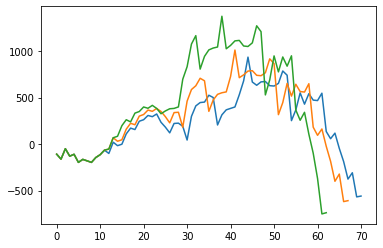

In [132]:
cont = 0
for i in gats:
    for j in encr:
        des = pd.DataFrame(testes[cont])
        print(f'Soma: {float(des.sum()):.4f} | Gati={i},Encr={j}')
#         print(des.describe())
        print('\n')
        plt.plot(des)
        cont+=1

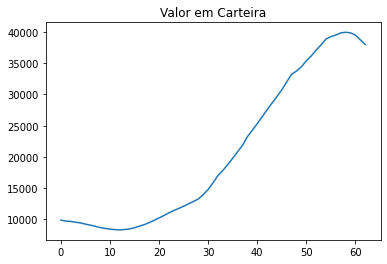

In [133]:
plt.title('Valor em Carteira')
plt.plot(result[1])
plt.show()